## yfactor_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、20 IF の hot / cold の oneshot と y-factor が表示されます
- 特筆事項：
  - 20 IF 分のデータが存在しなくても、存在する IF データのみで plot 可能です
-  <font color="red">notebook 上で plot を行いたい場合：　</font>
  - 上から順番に実行していただければ、plot が表示されます
  - 画像を保存したくない場合は、「plt.savefig」 をコメントアウトしてください

### モジュールを import します。

In [44]:
import os
import sys
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
if sys.argv[1] == 'xxx': pass
else: 
    %matplotlib inline

import necstdb

### database を読み込みます。

In [45]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190908_115337'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

### hot, cold, y-factor, Trx を計算します。

In [46]:
IF_list = tqdm([
    '2l_u', '2l_l', '2r_u', '2r_l',
    '3l_u', '3l_l', '3r_u', '3r_l',
    '4l_u', '4l_l', '4r_u', '4r_l',
    '5l_u', '5l_l', '5r_u', '5r_l',
    '1l_u', '1l_l', '1r_u', '1r_l',    
])
d_hot, d_cold = {}, {}
for IF in IF_list:
    IF_spec_name = 'xffts_spec_{}'.format(IF)
    try:
        d_hot[IF_spec_name] = np.array(db_hot.open_table(IF_spec_name).read())
        d_cold[IF_spec_name] = np.array(db_cold.open_table(IF_spec_name).read())
        IF_list.set_description('info : {} db is loaded.'.format(IF))
    except:
        d_hot[IF_spec_name] = np.zeros((2, 2 ** 15 + 1)) # shape = (2, 32769)
        d_cold[IF_spec_name] = np.zeros((2, 2 ** 15 + 1))
        IF_list.set_description('alart : {} db is not exist.'.format(IF))        

info : 1r_l db is loaded.: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


In [47]:
hot, cold = {}, {}
try:
    for key, val_hot, val_cold in zip(d_hot.keys(), d_hot.values(), d_cold.values()):
        hot[key]= np.delete(np.average(val_hot, axis=0), 0)
        cold[key]= np.delete(np.average(val_cold, axis=0), 0)
except: pass        
# memory freeing    
del(d_hot)
del(d_cold)

In [48]:
freq = np.linspace(0, 2000, 2**15) / 1e3
Thot, Tcold = 300., 77.
yfac, Trx = {}, {}
for key, val_hot, val_cold in zip(hot.keys(), hot.values(), cold.values()):
    yfac[key] = val_hot / val_cold 
    Trx[key] = (Thot - Tcold) * (val_hot / val_cold) / ((val_hot / val_cold) - 1)

### yfactor を plot します。

100%|██████████| 20/20 [00:01<00:00, 12.15it/s]


info : Saved image. ( yfactor.png )


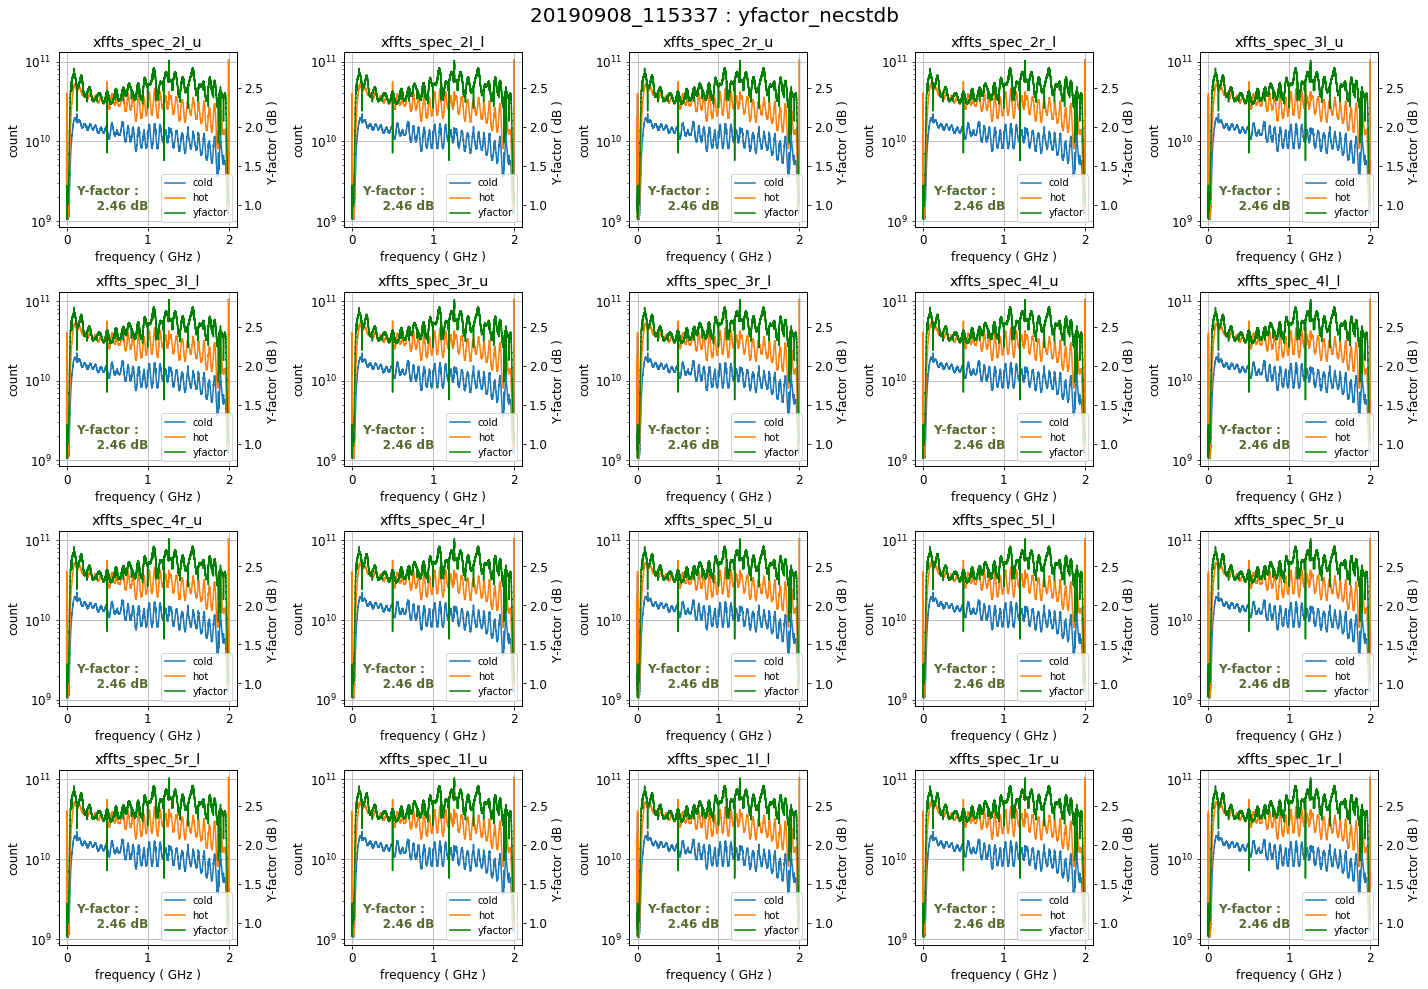

In [49]:
ncol = 5
nrow = 4
nax = ncol * nrow

figsize = (ncol * 4.0, nrow * 3.5)

matplotlib.rcParams['font.size'] = 12

fig = matplotlib.pyplot.figure(figsize=figsize)
ax = tqdm([fig.add_subplot(nrow, ncol, i+1) for i in range(nax)])

for _ax, board, _hot, _cold, _yfac in zip(ax, hot.keys(), hot.values(), cold.values(), yfac.values()):
        IF_list.set_description('info : {} db is loaded.'.format(IF))
    ax.set_description('info : ')
    _ax_ = _ax.twinx()
    
    _ax.plot(freq, _cold, label='cold')
    _ax.plot(freq, _hot, label='hot')
    _ax.set_xlabel('frequency ( GHz )')
    _ax.set_yscale('log')
    _ax.set_ylabel('count')
    _ax.set_title(board)
    _ax.grid()
    
    _ax_.plot(freq, _yfac, label='yfactor', c='g')
    _ax_.set_ylabel('Y-factor ( dB ) ')
    _ave_yfac = np.average(_yfac)
    _ax_.text(0.1, 0.1, 'Y-factor : \n     {:.2f} dB'.format(_ave_yfac), 
              color='darkolivegreen', fontweight='bold', transform=_ax.transAxes)
    
    h1, l1 = _ax.get_legend_handles_labels()
    h2, l2 = _ax_.get_legend_handles_labels()
    _ax_.legend(h1 + h2, l1 + l2, loc='lower right', fontsize=10)
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./yfactor.png')
print('info : Saved image. ( yfactor.png )')